In [1]:
from google.colab import files
files =files.upload()

Saving t10k-images-idx3-ubyte.gz to t10k-images-idx3-ubyte.gz
Saving t10k-labels-idx1-ubyte.gz to t10k-labels-idx1-ubyte.gz
Saving train-images-idx3-ubyte.gz to train-images-idx3-ubyte.gz
Saving train-labels-idx1-ubyte.gz to train-labels-idx1-ubyte.gz


In [2]:
import time
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore", message=r"Passing", category=FutureWarning)


class MLP:
    def __init__(self, sizes, epochs=10, l_rate=0.001, activation_fn='relu', dropout=False, dropout_prob=0.5, momentum=0.0):
        self.sizes = sizes      # sizes of each hidden layer
        self.epochs = epochs
        self.l_rate = l_rate
        self.hidden_layers = len(sizes)
        self.momentum = momentum        # reference https://machinelearningmastery.com/gradient-descent-with-momentum-from-scratch/

        # Used for plotting after training is finished
        self.losses = []
        self.accuracies = []
        self.epoch_plt = []

        # Dropout reference https://d2l.ai/chapter_multilayer-perceptrons/dropout.html#implementation-from-scratch
        # We apply dropout only on hidden layers. We performed inverted dropout, the method most used in practice.
        self.dropout_prob = dropout_prob        # most literature I read states 0.5 is a good value
        self.dropout = dropout

        if self.hidden_layers == 2:
            # number of nodes in each layer
            self.hidden_1 = self.sizes[0]
            self.hidden_2 = self.sizes[1]

        if self.hidden_layers == 1:
            self.hidden_1 = self.sizes[0]

        if self.hidden_layers == 0:
            pass        # Don't need to store anything in this case

        if  activation_fn == 'relu':
            self.activation_fn = self.relu
            self.activation_name = 'relu'
        elif activation_fn == 'tanh':
            self.activation_fn = self.tanh
            self.activation_name = 'tanh'
        elif activation_fn == 'leaky_relu':
            self.activation_fn = self.leaky_relu
            self.activation_name = 'leaky_relu'

    def __str__(self):
        return f'MLP with {self.hidden_layers} hidden layers, {self.activation_name} activation function, {self.l_rate}' \
               f' learning rate and dropout = {self.dropout}, momentum = {self.momentum}  '

    def relu(self, z, derivative=False):
        if derivative:
            _z = np.copy(z)
            _z[_z <= 0] = 0
            _z[_z > 0] = 1
            return _z
        return np.maximum(z, 0)

    def softmax(self, x, derivative=False):
        exps = np.exp(x - x.max())      # for numeric stability
        if derivative:
            return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))
        return exps / np.sum(exps, axis=0)

    def tanh(self, x, derivative=False):
        def tan_h(x):
            return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))
        if derivative:
            return 1 - tan_h(x) * tan_h(x)
        else:
            return tan_h(x)

    def leaky_relu(self, x, derivative=False, slope=0.05):
        if derivative:
            dx = np.ones_like(x)
            dx[x < 0] = slope
            return dx
        else:
            return np.where(x > 0, x, x * slope)

    # Pushes input through all layers and returns output of last layer
    def forward_pass(self, x_train):
        params = self.params

        if self.hidden_layers == 2:
            # A0 is one sample
            params['A0'] = x_train.T

            # input layer to hidden layer 1  𝜎(𝑉𝑥)
            params['Z1'] = np.dot(params['V'], params['A0']) + params['bias1'] # (128 x 784) x (784 x 1) = (128 x 1)
            params['A1'] = self.activation_fn(params['Z1'])  # 128 x 1
            params['A1'] *= params['mask1']     # dropout
            params['A1'] /= self.dropout_prob   # perform inverted dropout

            # hidden layer 1 to hidden layer 2   𝜎(𝑊𝜎(𝑉𝑥))
            params['Z2'] = np.dot(params['W'], params['A1']) + params['bias2']# (128 x 128) x (128 x 1) = (128 x 1)
            params['A2'] = self.activation_fn(params['Z2'])  # (128 x 1)
            params['A2'] *= params['mask2']     # dropout
            params['A2'] /= self.dropout_prob   # perform inverted dropout

            # hidden layer 2 to output layer   𝜎(U𝜎(𝑊𝜎(𝑉𝑥)))
            params['Z3'] = np.dot(params['U'], params['A2'])  + params['bias3']  # (10 x 128) x (128 x 1)
            params['A3'] = self.softmax(params['Z3'])           # (10 x 1)

            # Return the output of the final layer (i.e., predictions)
            return params['A3']

        if self.hidden_layers == 1:
            # A0 is one sample
            params['A0'] = x_train.T

            # input layer to hidden layer 1  𝜎(𝑉𝑥)
            params['Z1'] = np.dot(params['V'], params['A0']) + params['bias1']  # (128 x 784) x (784 x 1) = (128 x 1)
            params['A1'] = self.activation_fn(params['Z1'])  # 128 x 1

            # hidden layer 1 to output layer  𝜎(𝑊𝜎(𝑉𝑥))
            params['Z2'] = np.dot(params['W'], params['A1']) + params['bias2']  # (10 x 128) x (128 x 1) = (128 x 1)
            params['A2'] = self.softmax(params['Z2'])  # (10 x 1)

            # Return the output of the final layer (i.e., predictions)
            return params['A2']

        if self.hidden_layers == 0:
            params['A0'] = x_train.T

            # input layer to output layer  𝜎(𝑉𝑥)
            params['Z1'] = np.dot(params['V'], params['A0']) + params['bias1'] # (10 x 784) x (784 x 1) = (10 x 1)
            params['A1'] = self.softmax(params['Z1'])  # 10 x 1

            return params['A1']

    # Calculates Jacobians based on output of last layer
    def backward_pass(self, y_train, yh):

        params = self.params
        w_gradients = {}
        loss = yh - y_train

        # This chain follows the general observation in the slides that the Jacobian
        # = error from layer above x input from layer below. Bias update is derived from
        # https://datascience.stackexchange.com/a/20142

        if self.hidden_layers == 2:
            # Calculate U update
            error = 2 * loss / yh.shape[0] * self.softmax(params['Z3'], derivative=True)
            w_gradients['U'] = np.outer(error, params['A2'])
            w_gradients['bias3'] = params['Z3']

            # Calculate W update
            error = np.dot(params['U'].T, error) * self.activation_fn(params['Z2'], derivative=True)
            w_gradients['W'] = np.outer(error, params['A1'])
            w_gradients['bias2'] = params['Z2']

            # Calculate V update
            error = np.dot(params['W'].T, error) * self.activation_fn(params['Z1'], derivative=True)
            w_gradients['V'] = np.outer(error, params['A0'])
            w_gradients['bias3'] = params['Z3']

        if self.hidden_layers == 1:
            # Calculate W update
            error = 2 * loss / yh.shape[0] * self.softmax(params['Z2'], derivative=True)
            w_gradients['W'] = np.outer(error, params['A1'])
            w_gradients['bias2'] = params['Z2']

            # Calculate V update
            error = np.dot(params['W'].T, error) * self.activation_fn(params['Z1'], derivative=True)
            w_gradients['V'] = np.outer(error, params['A0'])
            w_gradients['bias1'] = params['Z1']

        if self.hidden_layers == 0:
            # Calculate V update
            error = 2 * loss / yh.shape[0] * self.softmax(params['Z1'], derivative=True)
            w_gradients['V'] = np.outer(error, params['A0'])
            w_gradients['bias1'] = params['Z1']

        return w_gradients, np.mean(np.square(loss))

    def predict(self, X):
        predictions = []
        for x in X:
            final_layer_op = self.forward_pass(x)
            pred = np.argmax(final_layer_op)
            predictions.append(pred)
        return predictions

    def fit(self, X_train, y_train):

        input_layer_size = X_train.shape[1]
        output_layer_size = y_train.shape[1]        # Always 10 for this assignment
        print(f'Training {self}')

        '''
        Store weight matrices. Each weight matrix will be between two layers, so its dimensions will
        be (size of next layer X size of previous layer).
        We use a form of Xavier initialization, reference: https://www.deeplearning.ai/ai-notes/initialization/
        '''
        if self.hidden_layers == 2:
            '''
            Following conventions in the slides:
            - V is weight matrix between input and hidden layer 1
            - W is weight matrix between hidden layer 1 and hidden layer 2
            - U is weight matrix between hidden layer 2 and output (softmax) [Not mentioned in slides]
            '''
            self.params = {
                'V': np.random.randn(self.hidden_1, input_layer_size) * np.sqrt(1. / self.hidden_1),
                'bias1': np.random.randn(self.hidden_1) * np.sqrt(1. / self.hidden_1),
                'W': np.random.randn(self.hidden_2, self.hidden_1) * np.sqrt(1. / self.hidden_2),
                'bias2': np.random.randn(self.hidden_2) * np.sqrt(1. / self.hidden_2),
                'U': np.random.randn(output_layer_size, self.hidden_2) * np.sqrt(1. / output_layer_size),
                'bias3': np.random.randn(output_layer_size) * np.sqrt(1. / output_layer_size)
            }

            # By default these masks do nothing unless they get changed later
            self.params['mask1'] = np.ones_like(self.params['bias1'])   # for hidden layer 1
            self.params['mask2'] = np.ones_like(self.params['bias2'])   # for hidden layer 2

        if self.hidden_layers == 1:
            '''
            Following conventions in the slides:
            - V is weight matrix between input and hidden layer 1
            - W is weight matrix between hidden layer 1 and output (softmax)
            '''
            self.params = {
                'V': np.random.randn(self.hidden_1, input_layer_size) * np.sqrt(1. / self.hidden_1),
                'bias1': np.random.randn(self.hidden_1) * np.sqrt(1. / self.hidden_1),
                'W': np.random.randn(output_layer_size, self.hidden_1) * np.sqrt(1. / output_layer_size),
                'bias2': np.random.randn(output_layer_size) * np.sqrt(1. / output_layer_size)
            }

        if self.hidden_layers == 0:
            '''
            Following conventions in the slides:
            - V is weight matrix between input and output layer (softmax with 10 classes)
            '''
            self.params = {
                'V': np.random.randn(output_layer_size, input_layer_size) * np.sqrt(1. / output_layer_size),
                'bias1': np.random.randn(output_layer_size) * np.sqrt(1. / output_layer_size)
            }

        start_time = time.time()
        # Run training loop for specified number of epochs
        for iteration in range(self.epochs):

            # Calculate dropout in layers. Does nothing if dropout is not enabled.
            if self.dropout and self.hidden_layers == 2:
                self.params['mask1'] = np.random.uniform(0, 1, self.params['bias1'].shape) > self.dropout_prob
                self.params['mask2'] = np.random.uniform(0, 1, self.params['bias2'].shape) > self.dropout_prob

            # Shuffle training data to make it stochastic
            permutation = np.random.permutation(len(X_train))
            X_train = X_train[permutation]
            y_train = y_train[permutation]

            previous_gradients = {}
            if self.momentum != 0:
                # Only initialize this if we're using momentum, otherwise it's not needed.
                for key, value in self.params.items():
                    previous_gradients[key] = np.zeros_like(value)

            # Although calculating one by one is inefficient,
            # it makes it easier to implement and understand. This is essentially SGD with minibatch size = 1,
            # reference: https://stats.stackexchange.com/a/337644
            for x, y in zip(X_train, y_train):
                train_predictions = self.forward_pass(x)

                # Calculate Jacobians for weights and biases
                gradients, loss = self.backward_pass(y, train_predictions)

                # Update all weights and biases i.e. perform gradient descent.
                # By default momentum is 0, which is equivalent to vanilla SGD.
                # Momentum reference: https://machinelearningmastery.com/gradient-descent-with-momentum-from-scratch/
                velocities = {}

                if self.momentum == 0:
                    # If we're not using momentum perform the simple gradient descent step.
                    for key, gradient in gradients.items():
                        self.params[key] -= self.l_rate * gradient
                else:
                    # Else we're using momentum. If momentum = 0, the following equations are mathematically the same
                    # as vanilla SGD. However, handling momentum = 0 case separately allows us to avoid unnecessary
                    # time consuming computations.
                    for key, gradient in gradients.items():
                        velocities[key] = self.l_rate * gradient + self.momentum * previous_gradients[key]
                        self.params[key] -= velocities[key]
                        previous_gradients[key] = velocities[key]

            # Get training accuracy
            predictions = self.predict(X_train)
            accuracy = eval_acc(predictions, y_train)

            print(f'Epoch {iteration+1}, time spent: {round(time.time() - start_time,2)}s, loss: {round(loss,15)}, accuracy: {round(accuracy*100, 2)}%')

            self.losses.append(loss)
            self.accuracies.append(accuracy)
            self.epoch_plt.append(iteration+1)

    def plot(self):
        # Plots stored losses and accuracies over epoches and saves to file
        self.epoch_plt = np.array(self.epoch_plt)
        self.accuracies = np.array(self.accuracies)
        self.losses = np.array(self.losses)

        df = pd.DataFrame({'epoch':self.epoch_plt,'acc%':self.accuracies,'loss':self.losses})
        df.to_csv(f'{self}')

        plt.figure(1)
        plt.plot(self.accuracies * 100, label=f'{self.hidden_layers} hidden layers + {self.activation_name}')
        plt.xlabel('Epoch number')
        plt.ylabel('Accuracy %')
        plt.title(f'Training accuracy v/s epoch')
        plt.legend()

        plt.figure(2)
        plt.plot(self.losses, label=f'{self.hidden_layers} hidden layers + {self.activation_name}')
        plt.xlabel('Epoch number')
        plt.ylabel('Loss')
        plt.title(f'Training loss v/s epoch')
        plt.legend()


def eval_acc(predicted, actual):
    acc = []
    for pred, act in zip(predicted, actual):
        acc.append(pred == np.argmax(act))

    return np.mean(acc)


def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels


def preprocess(data, normalize=True):
    # Center the data by making mean 0
    data = data - np.mean(data, axis=0)
    if normalize:
        # remove any scaling assumptions by dividing by std (z-score standardization)
        data = data / np.std(data, axis=0)
    return data


def load_data(normalize=True):
    # load_mnist returns flattened data
    X_train, y_train = load_mnist('./', kind='train')
    X_train = preprocess(X_train, normalize=normalize)  # center and normalize along each feature
    X_test, y_test = load_mnist('./', kind='t10k')
    X_test = preprocess(X_test, normalize=normalize)

    # Using Keras ONLY FOR one hot encoding
    from keras.utils.np_utils import to_categorical
    print('Note that we are using Keras ONLY FOR one hot encoding')
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = load_data()

# We sometimes see loss and accuracy both increasing. See https://stats.stackexchange.com/a/341054 for an explanation.
def task_3_1():
    print('******************* TASK 3.1 *****************************')
    mlp_0_hiddenlayer = MLP(sizes=[], epochs=50, l_rate=0.0001, activation_fn='relu', dropout=False)
    mlp_0_hiddenlayer.fit(X_train, y_train)
    predictions = mlp_0_hiddenlayer.predict(X_test)
    test_accuracy = eval_acc(predictions, y_test)
    print(f'Testing accuracy for {mlp_0_hiddenlayer}: {round(test_accuracy * 100, 2)}%')
    mlp_0_hiddenlayer.plot()

    mlp_1_hiddenlayer = MLP(sizes=[128], epochs=50, l_rate=0.0001, activation_fn='relu', dropout=False)
    mlp_1_hiddenlayer.fit(X_train, y_train)
    predictions = mlp_1_hiddenlayer.predict(X_test)
    test_accuracy = eval_acc(predictions, y_test)
    print(f'Testing accuracy for {mlp_1_hiddenlayer}: {round(test_accuracy * 100, 2)}%')
    mlp_1_hiddenlayer.plot()

    mlp_2_hiddenlayer = MLP(sizes=[128, 128], epochs=50, l_rate=0.0001, activation_fn='relu', dropout=False)
    mlp_2_hiddenlayer.fit(X_train, y_train)
    predictions = mlp_2_hiddenlayer.predict(X_test)
    test_accuracy = eval_acc(predictions, y_test)
    print(f'Testing accuracy for {mlp_2_hiddenlayer}: {round(test_accuracy * 100, 2)}%')
    mlp_2_hiddenlayer.plot()

    plt.legend()
    plt.show()

def task_3_2():
    print('******************* TASK 3.2 *****************************')
    mlp_2_hiddenlayer_tanh = MLP(sizes=[128, 128], epochs=50, l_rate=0.0001, activation_fn='tanh', dropout=False)
    mlp_2_hiddenlayer_tanh.fit(X_train, y_train)
    predictions = mlp_2_hiddenlayer_tanh.predict(X_test)
    test_accuracy = eval_acc(predictions, y_test)
    print(f'Testing accuracy for {mlp_2_hiddenlayer_tanh}: {round(test_accuracy * 100, 2)}%')
    mlp_2_hiddenlayer_tanh.plot()

    mlp_2_hiddenlayer_leaky = MLP(sizes=[128, 128], epochs=50, l_rate=0.0001, activation_fn='leaky_relu', dropout=False)
    mlp_2_hiddenlayer_leaky.fit(X_train, y_train)
    predictions = mlp_2_hiddenlayer_leaky.predict(X_test)
    test_accuracy = eval_acc(predictions, y_test)
    print(f'Testing accuracy for {mlp_2_hiddenlayer_leaky}: {round(test_accuracy * 100, 2)}%')
    mlp_2_hiddenlayer_leaky.plot()

    mlp_2_hiddenlayer_relu = MLP(sizes=[128, 128], epochs=50, l_rate=0.0001, activation_fn='relu', dropout=False)
    mlp_2_hiddenlayer_relu.fit(X_train, y_train)
    predictions = mlp_2_hiddenlayer_relu.predict(X_test)
    test_accuracy = eval_acc(predictions, y_test)
    print(f'Testing accuracy for {mlp_2_hiddenlayer_relu}: {round(test_accuracy * 100, 2)}%')
    mlp_2_hiddenlayer_relu.plot()

    plt.legend()
    plt.show()


def task_3_3():
    print('******************* TASK 3.3 *****************************')
    mlp_2_hiddenlayer_dropout = MLP(sizes=[128, 128], epochs=50, l_rate=0.0001, activation_fn='relu', dropout=True)
    mlp_2_hiddenlayer_dropout.fit(X_train, y_train)
    predictions = mlp_2_hiddenlayer_dropout.predict(X_test)
    test_accuracy = eval_acc(predictions, y_test)
    print(f'Testing accuracy for {mlp_2_hiddenlayer_dropout}: {round(test_accuracy * 100, 2)}%')
    mlp_2_hiddenlayer_dropout.plot()

    plt.legend()
    plt.show()


def task_3_4():
    print('******************* TASK 3.4 *****************************')
    X_train, y_train, X_test, y_test = load_data(normalize=False)

    mlp_2_hiddenlayer_unnormalized = MLP(sizes=[128, 128], epochs=50, l_rate=0.0001, activation_fn='relu', dropout=False)
    mlp_2_hiddenlayer_unnormalized.fit(X_train, y_train)
    predictions = mlp_2_hiddenlayer_unnormalized.predict(X_test)
    test_accuracy = eval_acc(predictions, y_test)
    print(f'Testing accuracy for {mlp_2_hiddenlayer_unnormalized}: {round(test_accuracy * 100, 2)}%')
    mlp_2_hiddenlayer_unnormalized.plot()

    plt.legend()
    plt.show()


def task_3_5():
    print('******************* TASK 3.5 *****************************')
    pass    # done in the other notebook

def task_3_6():
    print('******************* TASK 3.6 *****************************')

    mlp_2_hiddenlayer_best = MLP(sizes=[128, 128], epochs=50, l_rate=0.0001, activation_fn='tanh', dropout=False, momentum=0.7)
    mlp_2_hiddenlayer_best.fit(X_train, y_train)
    predictions = mlp_2_hiddenlayer_best.predict(X_test)
    test_accuracy = eval_acc(predictions, y_test)
    print(f'Testing accuracy for {mlp_2_hiddenlayer_best}: {round(test_accuracy * 100, 2)}%')
    mlp_2_hiddenlayer_best.plot()
    plt.legend()
    plt.show()

    mlp_2_hiddenlayer_best = MLP(sizes=[128], epochs=50, l_rate=0.0001, activation_fn='tanh', dropout=False, momentum=0.7)
    mlp_2_hiddenlayer_best.fit(X_train, y_train)
    predictions = mlp_2_hiddenlayer_best.predict(X_test)
    test_accuracy = eval_acc(predictions, y_test)
    print(f'Testing accuracy for {mlp_2_hiddenlayer_best}: {round(test_accuracy * 100, 2)}%')
    mlp_2_hiddenlayer_best.plot()
    plt.legend()
    plt.show()



Note that we are using Keras ONLY FOR one hot encoding


Note that we are using Keras ONLY FOR one hot encoding
******************* TASK 3.1 *****************************
Training MLP with 0 hidden layers, relu activation function, 0.0001 learning rate and dropout = False, momentum = 0.0  
Epoch 1, time spent: 7.53s, loss: 0.197835003011981, accuracy: 15.2%
Epoch 2, time spent: 15.08s, loss: 6.242682685e-06, accuracy: 17.8%
Epoch 3, time spent: 22.51s, loss: 0.000531314311853, accuracy: 20.57%
Epoch 4, time spent: 29.97s, loss: 0.193178474579885, accuracy: 23.97%
Epoch 5, time spent: 37.49s, loss: 0.01129577643445, accuracy: 27.67%
Epoch 6, time spent: 44.94s, loss: 0.195055393942716, accuracy: 30.96%
Epoch 7, time spent: 52.33s, loss: 0.150016427977898, accuracy: 33.1%
Epoch 8, time spent: 59.81s, loss: 0.173753513011435, accuracy: 34.71%
Epoch 9, time spent: 67.32s, loss: 0.113332547563702, accuracy: 35.98%
Epoch 10, time spent: 74.78s, loss: 0.0, accuracy: 37.07%
Epoch 11, time spent: 82.26s, loss: 0.111892753144591, accuracy: 38.16%
Epoc

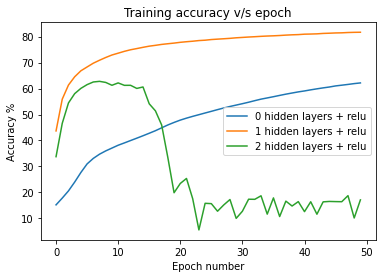

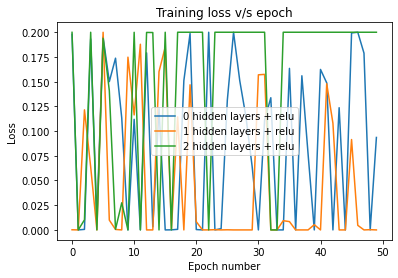

******************* TASK 3.2 *****************************
Training MLP with 2 hidden layers, tanh activation function, 0.0001 learning rate and dropout = False, momentum = 0.0  
Epoch 1, time spent: 80.92s, loss: 1.2196091551e-05, accuracy: 24.32%
Epoch 2, time spent: 162.4s, loss: 0.1460702503851, accuracy: 36.88%
Epoch 3, time spent: 245.34s, loss: 0.148913372280092, accuracy: 44.86%
Epoch 4, time spent: 326.5s, loss: 0.182637142765942, accuracy: 51.51%
Epoch 5, time spent: 409.0s, loss: 0.130533055953695, accuracy: 56.46%
Epoch 6, time spent: 490.3s, loss: 0.059450354677053, accuracy: 59.95%
Epoch 7, time spent: 574.65s, loss: 3.54926e-10, accuracy: 62.66%
Epoch 8, time spent: 657.07s, loss: 0.132147010359003, accuracy: 64.63%
Epoch 9, time spent: 735.18s, loss: 0.154014717536987, accuracy: 66.33%
Epoch 10, time spent: 813.63s, loss: 0.000232062423151, accuracy: 67.68%
Epoch 11, time spent: 891.89s, loss: 0.199362591592306, accuracy: 68.69%
Epoch 12, time spent: 969.91s, loss: 0.15

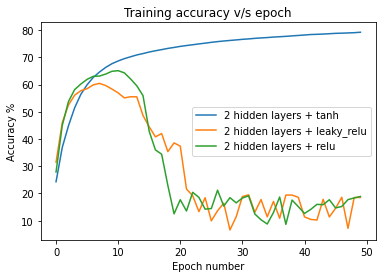

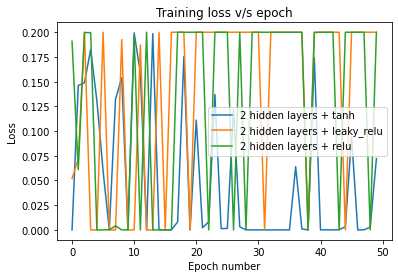

******************* TASK 3.3 *****************************
Training MLP with 2 hidden layers, relu activation function, 0.0001 learning rate and dropout = True, momentum = 0.0  
Epoch 1, time spent: 69.9s, loss: 0.129434169540136, accuracy: 34.09%
Epoch 2, time spent: 142.51s, loss: 8.22762407e-07, accuracy: 30.85%
Epoch 3, time spent: 210.41s, loss: 0.00136720000276, accuracy: 45.07%
Epoch 4, time spent: 279.79s, loss: 0.000952416625011, accuracy: 42.68%
Epoch 5, time spent: 351.17s, loss: 7.3743991079e-05, accuracy: 44.42%
Epoch 6, time spent: 423.64s, loss: 0.176823014225183, accuracy: 45.93%
Epoch 7, time spent: 494.03s, loss: 0.150728537195024, accuracy: 45.79%
Epoch 8, time spent: 564.48s, loss: 3.9e-14, accuracy: 52.21%
Epoch 9, time spent: 634.0s, loss: 0.199780934707489, accuracy: 45.03%
Epoch 10, time spent: 702.76s, loss: 0.199999999999038, accuracy: 38.12%
Epoch 11, time spent: 774.09s, loss: 0.199999066417732, accuracy: 36.42%
Epoch 12, time spent: 844.98s, loss: 3.1087678

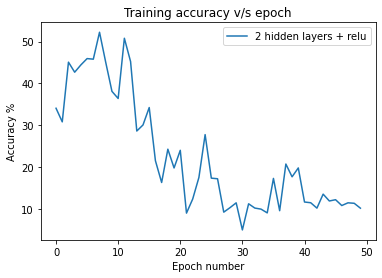

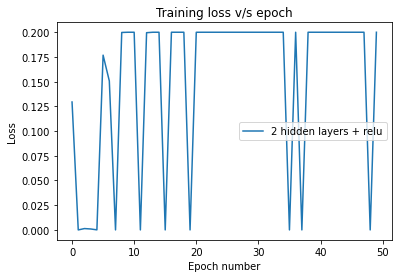

******************* TASK 3.4 *****************************
Note that we are using Keras ONLY FOR one hot encoding
Training MLP with 2 hidden layers, relu activation function, 0.0001 learning rate and dropout = False, momentum = 0.0  
Epoch 1, time spent: 69.15s, loss: 0.2, accuracy: 29.71%
Epoch 2, time spent: 138.31s, loss: 0.0, accuracy: 50.72%
Epoch 3, time spent: 206.44s, loss: 0.0, accuracy: 56.18%
Epoch 4, time spent: 274.55s, loss: 0.2, accuracy: 55.94%
Epoch 5, time spent: 342.21s, loss: 0.2, accuracy: 57.15%
Epoch 6, time spent: 409.5s, loss: 0.2, accuracy: 55.38%
Epoch 7, time spent: 476.72s, loss: 0.2, accuracy: 50.99%
Epoch 8, time spent: 543.52s, loss: 0.2, accuracy: 57.48%
Epoch 9, time spent: 610.31s, loss: 0.0, accuracy: 53.09%
Epoch 10, time spent: 677.41s, loss: 0.0, accuracy: 57.14%
Epoch 11, time spent: 742.74s, loss: 0.0, accuracy: 51.72%
Epoch 12, time spent: 808.65s, loss: 0.0, accuracy: 48.67%
Epoch 13, time spent: 875.27s, loss: 0.0, accuracy: 49.56%
Epoch 14, 

In [ ]:
task_3_1()
task_3_2()
task_3_3()

******************* TASK 3.4 *****************************
Note that we are using Keras ONLY FOR one hot encoding
Training MLP with 2 hidden layers, relu activation function, 0.0001 learning rate and dropout = False, momentum = 0.0  
Epoch 1, time spent: 61.89s, loss: 0.0, accuracy: 32.12%
Epoch 2, time spent: 122.69s, loss: 0.0, accuracy: 49.82%
Epoch 3, time spent: 182.7s, loss: 0.0, accuracy: 56.16%
Epoch 4, time spent: 242.36s, loss: 0.0, accuracy: 58.71%
Epoch 5, time spent: 302.48s, loss: 0.0, accuracy: 61.2%
Epoch 6, time spent: 362.0s, loss: 0.0, accuracy: 60.67%
Epoch 7, time spent: 421.76s, loss: 0.0, accuracy: 60.17%
Epoch 8, time spent: 480.89s, loss: 0.0, accuracy: 60.52%
Epoch 9, time spent: 540.64s, loss: 0.0, accuracy: 57.97%
Epoch 10, time spent: 599.79s, loss: 0.2, accuracy: 57.05%
Epoch 11, time spent: 659.27s, loss: 0.2, accuracy: 59.36%
Epoch 12, time spent: 718.22s, loss: 0.2, accuracy: 56.72%
Epoch 13, time spent: 777.94s, loss: 0.2, accuracy: 53.08%
Epoch 14, ti

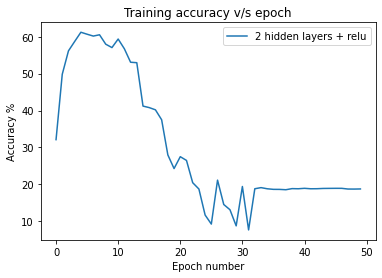

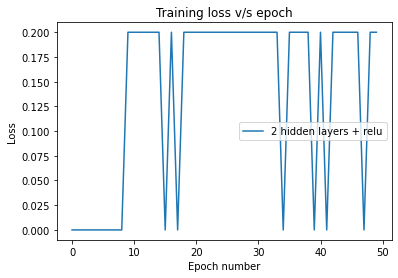

******************* TASK 3.5 *****************************
******************* TASK 3.6 *****************************
Training MLP with 2 hidden layers, tanh activation function, 0.0001 learning rate and dropout = False, momentum = 0.7  
Epoch 1, time spent: 85.45s, loss: 0.149624856126177, accuracy: 52.96%
Epoch 2, time spent: 170.52s, loss: 0.131958477475693, accuracy: 63.52%
Epoch 3, time spent: 255.56s, loss: 0.024334930915621, accuracy: 68.13%
Epoch 4, time spent: 340.25s, loss: 0.001848480366233, accuracy: 70.69%
Epoch 5, time spent: 424.95s, loss: 0.006322445452326, accuracy: 72.42%
Epoch 6, time spent: 509.8s, loss: 2.57617461e-07, accuracy: 73.69%
Epoch 7, time spent: 594.66s, loss: 0.18925263779593, accuracy: 74.73%
Epoch 8, time spent: 679.77s, loss: 0.002051083254055, accuracy: 75.56%
Epoch 9, time spent: 764.4s, loss: 3.4886269e-08, accuracy: 76.28%
Epoch 10, time spent: 849.41s, loss: 1.129902393e-06, accuracy: 76.78%
Epoch 11, time spent: 934.29s, loss: 6.428624e-08, acc

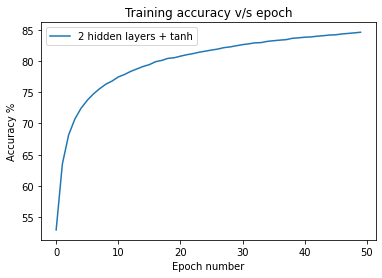

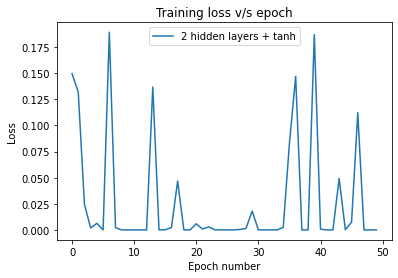

Training MLP with 1 hidden layers, tanh activation function, 0.0001 learning rate and dropout = False, momentum = 0.7  
Epoch 1, time spent: 69.2s, loss: 0.100373163848745, accuracy: 60.12%
Epoch 2, time spent: 137.05s, loss: 0.171157696135189, accuracy: 69.31%
Epoch 3, time spent: 205.23s, loss: 0.10573978917577, accuracy: 72.87%
Epoch 4, time spent: 273.48s, loss: 0.004161516394366, accuracy: 74.97%
Epoch 5, time spent: 342.04s, loss: 0.000176079450013, accuracy: 76.39%
Epoch 6, time spent: 410.01s, loss: 0.033478902571385, accuracy: 77.39%
Epoch 7, time spent: 478.55s, loss: 0.044507537110875, accuracy: 78.36%
Epoch 8, time spent: 546.4s, loss: 0.001705917586969, accuracy: 79.09%
Epoch 9, time spent: 614.77s, loss: 1.7364504246e-05, accuracy: 79.69%
Epoch 10, time spent: 682.76s, loss: 4.229853327e-06, accuracy: 80.14%
Epoch 11, time spent: 751.13s, loss: 0.000263986741821, accuracy: 80.53%
Epoch 12, time spent: 819.18s, loss: 0.131364567547229, accuracy: 81.01%
Epoch 13, time spent

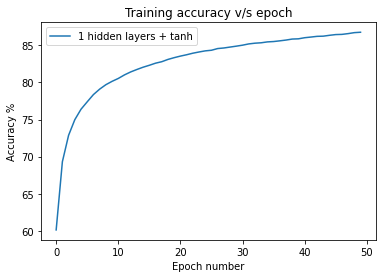

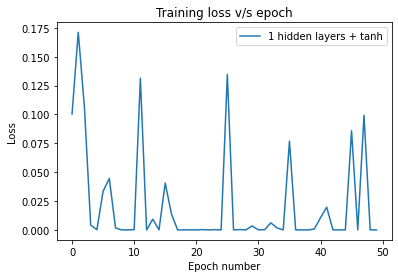

In [3]:
task_3_4()
task_3_5()
task_3_6()